# 02: Logistic Regression


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, mean_squared_error
import torch
from torch import nn

In the first part we created a neural network for linear regression (i.e. for a continuous output value $y$). In this part we'll move on to binary classification (i.e. where $y$ can belong to one of two classes $y \in \{0, 1\}$), starting with logistic regression.

## Why not just use linear regression for classification?

- Linear regression returns a continuous value ($-\infty \leq y \leq \infty$), but we want a class probability ($0 \leq y \leq 1$)
- Very sensitive to outliers/imbalanced data

Here's an example of using linear regression on a classification dataset with a single feature, $x$:

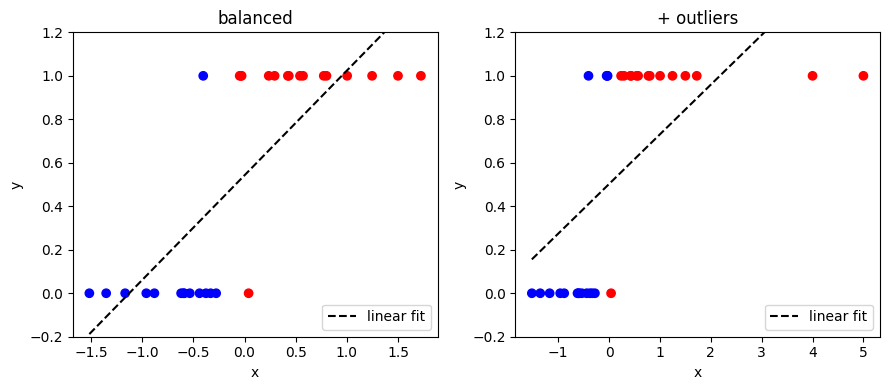

In [2]:
def fit_and_plot(x, y, title="", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    lr = LinearRegression()
    lr.fit(x.reshape(-1, 1), y)
    yhat = lr.predict(x.reshape(-1, 1))
    ax.scatter(x, y, c=yhat >= 0.5, cmap="bwr")
    ax.plot(x, yhat, "k--", label="linear fit")
    ax.set_ylim([-0.2, 1.2])
    ax.legend(loc="lower right")
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_title(title)


xy = np.loadtxt("../data/02_dummy_data.csv")
x = xy[:, 0]
y = xy[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
fit_and_plot(x, y, title="balanced", ax=ax[0])
fit_and_plot(np.append(x, [4, 5]), np.append(y, [1, 1]), title="+ outliers", ax=ax[1])
fig.tight_layout()

Note that:

- The range of $y$ is not limited to between 0 and 1
- The presence of the outliers changes the predicted class of a point (and e.g. changes the value of $y$ from around -0.2 to +0.2 for $x = -1.5$)

## The solution: Sigmoid

To get around this we apply the **sigmoid** function:

$$
\textrm{sigmoid}(z) = \frac{1}{1 + \exp(-z)}
$$

which is bounded between zero and one, and looks like this:

Text(0, 0.5, 'sigmoid(z)')

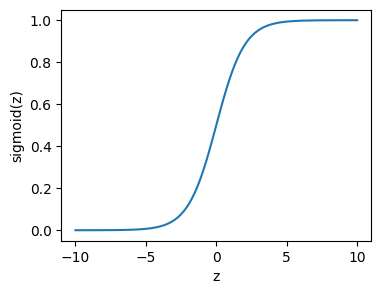

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


z = np.linspace(-10, 10, 100)
plt.figure(figsize=(4,3))
plt.plot(z, sigmoid(z))
plt.xlabel("z")
plt.ylabel("sigmoid(z)")

The logistic regression model is:

$$
\hat{y} = \textrm{sigmoid}(w x + b)
$$

So we still have a linear predictor ($z = wx + b$) on the input features, but we apply the sigmoid function to create our final output (mapping the continuous value of the linear predictor to be between zero and one).

## Loss Function

In linear regression we used mean squared error as the metric to optimise the weights of the model. In logistic regression we use the **log loss**, also known as the **(binary) cross-entropy** loss. It's defined as follows (remember that $y$, the true class, is always zero or one):

$$
L = - \frac{1}{N} \sum_i^N y_i \log(\hat{y_i}) + (1 - y_i)\log(1 - \hat{y_i})
$$

Which looks like this:

Text(0, 0.5, 'loss')

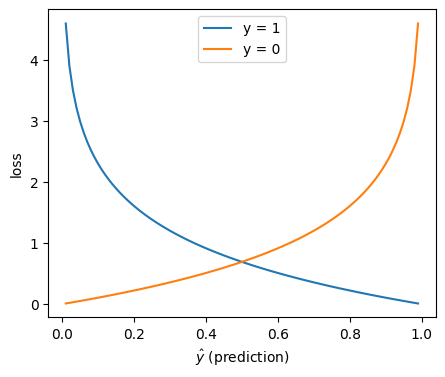

In [4]:
yhat = np.linspace(0.01, 0.99, 99)
plt.figure(figsize=(5, 4))
plt.plot(yhat, -np.log(yhat), label="y = 1")
plt.plot(yhat, -np.log(1 - yhat), label="y = 0")
plt.legend(loc="upper center")
plt.xlabel(r"$\hat{y}$ (prediction)")
plt.ylabel("loss")

Why not just use mean squared error?

- Using log loss gives the maximum likelihood estimator for logistic regression
- It's a convex function for logistic regression (but mean squared error is not), see below. So it's easier to optimise (no local minima).

Text(0.5, 0, 'loss')

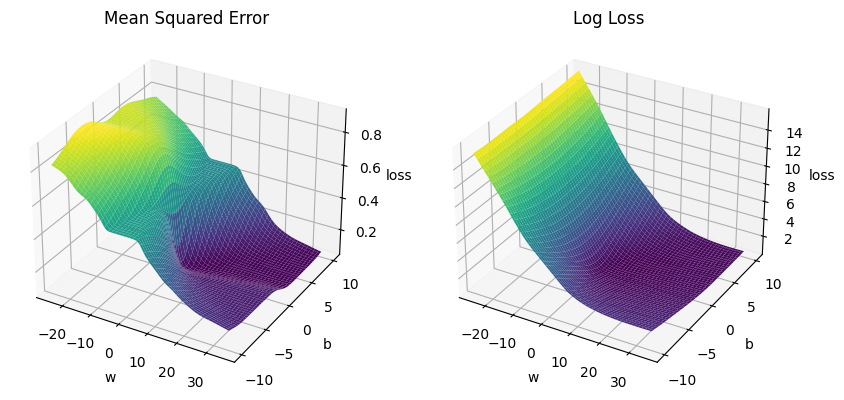

In [5]:
ws = np.linspace(-25, 35, 200)
bs = np.linspace(-10, 10, 200)

mse_ls = []
bce_ls = []
w_plot = []
b_plot = []
for w, b in itertools.product(ws, bs):
    w_plot.append(w)
    b_plot.append(b)
    yhat = sigmoid(w * x + b)
    mse_ls.append(mean_squared_error(y, yhat))
    bce_ls.append(log_loss(y, yhat))

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(10, 8))

surf = ax[0].plot_surface(
    np.array(w_plot).reshape((len(ws), len(bs))),
    np.array(b_plot).reshape((len(ws), len(bs))),
    np.array(mse_ls).reshape((len(ws), len(bs))),
    cmap="viridis"
)
ax[0].set_title("Mean Squared Error")
ax[0].set_xlabel("w")
ax[0].set_ylabel("b")
ax[0].set_zlabel("loss")

# Plot the surface.
surf = ax[1].plot_surface(
    np.array(w_plot).reshape((len(ws), len(bs))),
    np.array(b_plot).reshape((len(ws), len(bs))),
    np.array(bce_ls).reshape((len(ws), len(bs))),
    cmap="viridis"
)
ax[1].set_title("Log Loss")
ax[1].set_xlabel("w")
ax[1].set_ylabel("b")
ax[1].set_zlabel("loss")

## Neural Network for Logistic Regression

To modify our simple linear regression neural network for logistic regression we need to add an **activation function**:

![](../img/02_logistic_regression_net.png)

Where $z$ is still the a linear combination of the output node's inputs:

$$
z = w_1 x_1 + w_2 x_2 + b
$$

which then has the **sigmoid activation function**, $g(z)$, applied to it to create the final output:

$$
g(z) = \textrm{sigmoid}(z) = \frac{1}{1 + \exp(-z)}
$$

Often you'll see $g(z)$ (i.e. the computation of $z$ and the application of $g$) drawn as a single node in diagrams, rather than explicitly separating them.

## Pytorch

Here is a logistic regression "neural network" implemented in pytorch, which we'll use with the `BCELoss` (Binary Cross Entropy, aka the log loss defined earlier). Initially just for the dummy dataset we've used so far with a single input feature:

In [6]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=1),
    nn.Sigmoid()
)
print(model)

loss_fn = nn.BCELoss()

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)


For improved numerical stability (see [the pytorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) and [this article](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/) for details) it's preferred to combine the sigmoid and loss functions into one step. This is done by using `BCEWithLogitsLoss`:

In [7]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=1),
)
print(model)

loss_fn = nn.BCEWithLogitsLoss()

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


Note that sigmoid no longer appears in the network definition, and if the model is trained this way its output will be $z$, not $g(z)$ (i.e. we need to apply the sigmoid function to the output to recover the class probabilities).

Everything else about training the network is the same we saw in the first part for linear regression:

In [8]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
def train(X, y, model, loss_fn, optimizer, epochs):
    loss_history = []
    for e in range(epochs):
        # Compute prediction and loss
        pred = model(X)
        loss_value = loss_fn(pred, y)
        loss_history.append(float(loss_value))

        # Backpropagation
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

    print("Done!")
    return model, loss_history

In [10]:
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
x = x[:, None]
y = y[:, None]  # input and output needs to be 2D, [:, None] adds a second (length 1) axis

In [11]:
model, loss_history = train(x, y, model, loss_fn, optimizer, 15000)

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:]} \n")


Done!
Layer: 0.weight | Size: torch.Size([1, 1]) | Values : tensor([[5.4561]], grad_fn=<SliceBackward0>) 

Layer: 0.bias | Size: torch.Size([1]) | Values : tensor([0.8190], grad_fn=<SliceBackward0>) 



Here's the fit to the data:

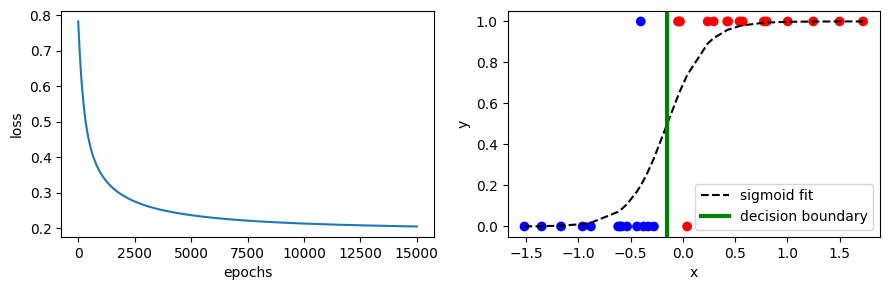

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].plot(loss_history)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")

yhat = sigmoid(model(x).detach().numpy())  # need to apply sigmoid here due to use of BCEWithLogitsLoss
ax[1].scatter(x, y, c=yhat>=0.5, cmap="bwr")
ax[1].plot(x, yhat, "k--", label="sigmoid fit")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
boundary = - model[0].bias[0].detach() / model[0].weight[0][0].detach()
ax[1].plot([boundary, boundary], [-0.1, 1.1], "g", linewidth=3, label="decision boundary")
ax[1].set_ylim([-0.05, 1.05])
ax[1].legend(loc="lower right")

fig.tight_layout()

Also shown is the **decision boundary** - all samples with $x$ to the left of the boundary are predicted to have $y = 0$, and all values to the right $y = 1$ (assuming we predict $y = 1$ when $\hat{y} \geq 0.5$).

## Adding a second feature

Now let's consider a more interesting dataset with two features, $x_1$, $x_2$, and a non-linear decision boundary. In this case samples belong to class 1 if $x_1^3 - x_1 - x_2 > 0$ (and class 0 otherwise): 

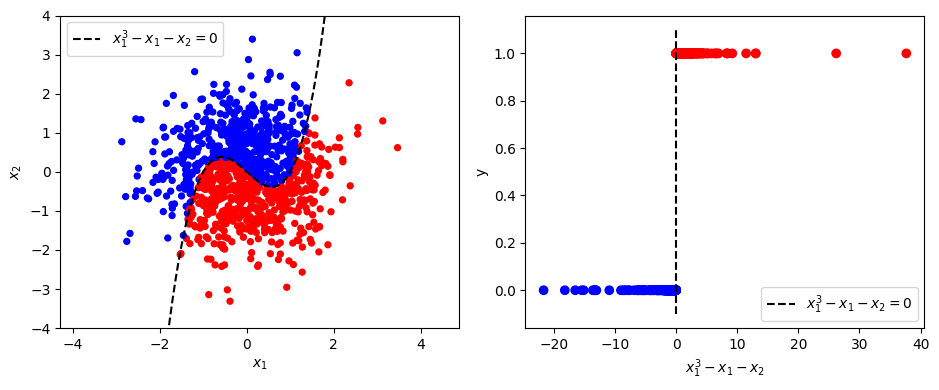

In [13]:
def get_cubic_data(n=1000):
    X = np.random.normal(size=(n, 2))
    y = X[:, 1] < (X[:, 0] ** 3) - X[:, 0]
    return X, y


X, y = get_cubic_data()

fig, ax = plt.subplots(1, 2, figsize=(9.5, 4))

ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", s=18)
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
x_span = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 1000)
ax[0].plot(x_span, x_span ** 3 - x_span, "k--", label="$x_1^3 - x_1 - x_2 = 0$")
ax[0].set_ylim([-4, 4])
ax[0].legend()

z = X[:, 0] ** 3 - X[:, 0] - X[:, 1]
ax[1].scatter(z, y, c=y, cmap="bwr")
ax[1].plot([0, 0], [-0.1, 1.1], "k--", label="$x_1^3 - x_1 - x_2 = 0$")
ax[1].legend()
ax[1].set_xlabel("$x_1^3 - x_1 - x_2$")
ax[1].set_ylabel("y")

fig.tight_layout()

## Pytorch 2-input Logistic Regression Network

In [14]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=1),  # 2 input features now (x_1, x_2)
    # Sigmoid (applied in loss_fn)
)

loss_fn = nn.BCEWithLogitsLoss()
# Reminder: BCEWithLogitsLoss both applies sigmoid to the output and computes the loss

## What type of decision boundary can this network fit (given $x_1$ and $x_2$)?

a) Linear

b) Non-linear

Reminder: We've added a non-linear activation function (sigmoid)

## Result

In [15]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
y = y[:, None]

In [16]:
def plot_decision_boundary(
    dataset,
    labels,
    model,
    steps=1000,
    cmap="bwr",
    ax=None,
    show_data=True,
    show_actual=True,
    title="Decision Boundary Fit",
    xlim=None,
    ylim=None,
    xlabel="$x_1$",
    ylabel="$x_2$",
    alpha=0.25,
    fig=None,
    vmin=0,
    vmax=1,
):
    """
    Adapted from:
    https://gist.github.com/erwan-simon/e3baef06a00bb9a39a6968acf78121ee
    """
    # Define region of interest by data limits
    if xlim:
        xmin, xmax = xlim
    else:
        xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    if ylim:
        ymin, ymax = ylim
    else:
        ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    if ax is None:
        fig, ax = plt.subplots()
    if fig is None:
        fig = ax.get_figure()

    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions
    labels_predicted = model(
        torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float)
    )
    labels_predicted = sigmoid(labels_predicted.detach().numpy())

    # Plot predictions
    z = np.array(labels_predicted).reshape(xx.shape)
    cf = ax.contourf(xx, yy, z, cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax)
    
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.2)
    fig.add_axes(cax)
    fig.colorbar(cf, cax=cax)

    # plot data
    if show_data:
        ax.scatter(
            dataset[:, 0],
            dataset[:, 1],
            c=labels.reshape(labels.size()[0]),
            cmap=cmap,
            lw=0,
            marker="."
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if not show_data and show_actual:
        ax.plot(x_span, x_span ** 3 - x_span, "k--", label="actual")
        ax.set_ylim([ymin, ymax])
        ax.legend()


def show_result(X, y, model, loss_history, print_weights=True, suptitle=""):
    if print_weights:
        for name, param in model.named_parameters():
            print(f"Layer: {name} | Size: {param.size()} | Values : {param[:]} \n")

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].plot(loss_history)
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    plot_decision_boundary(X, y, model, ax=ax[1], show_data=False)
    plot_decision_boundary(X, y, model, ax=ax[2], show_data=True, title="Data")
    fig.suptitle(suptitle)
    fig.tight_layout()

Done!
Layer: 0.weight | Size: torch.Size([1, 2]) | Values : tensor([[ 1.4231, -3.6309]], grad_fn=<SliceBackward0>) 

Layer: 0.bias | Size: torch.Size([1]) | Values : tensor([-0.0195], grad_fn=<SliceBackward0>) 



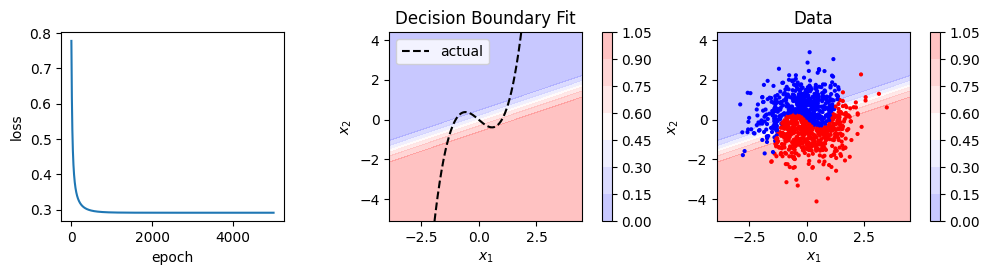

In [17]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model, loss_history = train(X, y, model, loss_fn, optimizer, 5000)

show_result(X, y, model, loss_history)

Logistic regression, and our neural network that recreates it, can only fit _linear_ decision boundaries. We could fit a non-linear boundary by adding polynomial features. In this case we'd need up cubic terms so we might try to fit something like this:

$$
z = w_1 x_1^3 + w_2 x_1^2 x_2 + w_3 x_1 x_2^2 + w_4 x_2^3 + w_5 x_1 ^2 + w_6 x_1 x_2 + w_7 x_2^2 + w_8 x_1 + w_9 x_2 + b \\
\hat{y} = \textrm{sigmoid}(z)
$$

Note that $z$ is linear in the weights so this is still logistic regression.

Could neural networks provide an alternative to creating all these features manually?

## Adding nodes and layers (moving away from logistic regression)

For our linear regression network with **no/linear/identity activation** we saw adding nodes and layers had no effect on the type of function that could be fitted. How about adding nodes/layers to our logistic regression network, which has **sigmoid activation**?

### 1 Hidden Layer

Let's add a hidden layer with 2 nodes:

![](../img/02_1hidden.png)

Note that we're also applying the activation function (in this case sigmoid) on the output of the hidden nodes.

#### What type of decision boundary can this network fit (given only the original features $x_1$ and $x_2$)?

a) Linear

b) Non-linear

Let's see. Here's the new network in pytorch:

Done!
Layer: 0.weight | Size: torch.Size([2, 2]) | Values : tensor([[-10.9469,  -9.0712],
        [ -1.4749,   0.8411]], grad_fn=<SliceBackward0>) 

Layer: 0.bias | Size: torch.Size([2]) | Values : tensor([-0.2956, -0.0164], grad_fn=<SliceBackward0>) 

Layer: 2.weight | Size: torch.Size([1, 2]) | Values : tensor([[ 14.8347, -25.4907]], grad_fn=<SliceBackward0>) 

Layer: 2.bias | Size: torch.Size([1]) | Values : tensor([5.3332], grad_fn=<SliceBackward0>) 



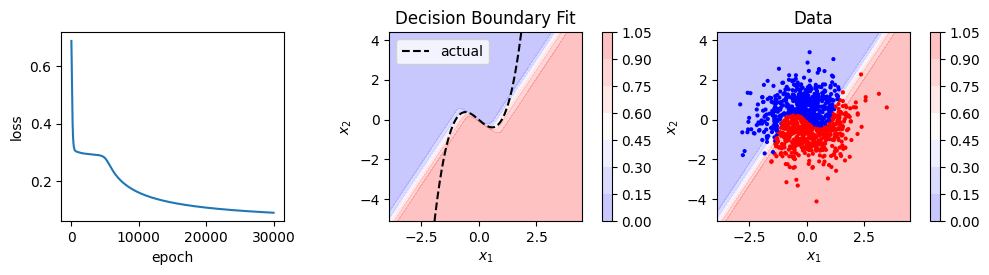

In [18]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1),
    #  Sigmoid (applied in loss_fn)
)

learning_rate = 0.2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model, loss_history = train(X, y, model, loss_fn, optimizer, 30000)

show_result(X, y, model, loss_history)

We get a non-linear decision boundary! But there's still a region where the network is uncertain/misclassifies  some points (e.g. the white region). What if we add another layer?

### 2 Hidden Layers

![](../img/02_2hidden.png)

Done!


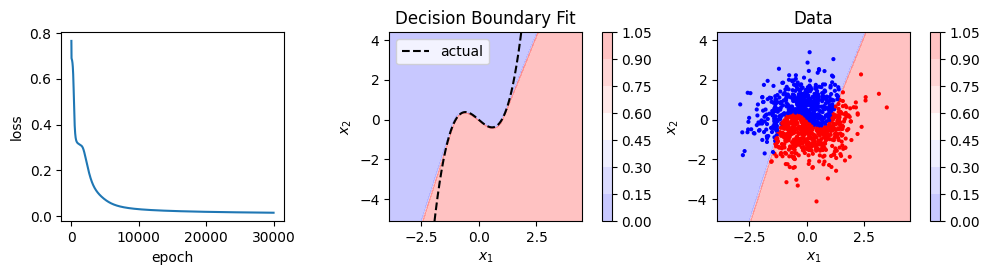

In [19]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=3),
    nn.Sigmoid(),
    nn.Linear(in_features=3, out_features=3),
    nn.Sigmoid(),
    nn.Linear(in_features=3, out_features=1),
    #  Sigmoid (applied in loss_fn)
)

learning_rate = 0.2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model, loss_history = train(X, y, model, loss_fn, optimizer, 30000)

show_result(X, y, model, loss_history, print_weights=False)

This network can almost perfectly fit the decision boundary the data was generated with.

## What's going on?

Let's go back to the one hidden layer network:

In [20]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=2),
    nn.Sigmoid(),
    nn.Linear(in_features=2, out_features=1),
    #  Sigmoid (applied in loss_fn)
)

learning_rate = 0.2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model, loss_history = train(X, y, model, loss_fn, optimizer, 30000)

Done!


We can visualise the input and output of each node to get an idea of how the non-linear decision boundary is created:

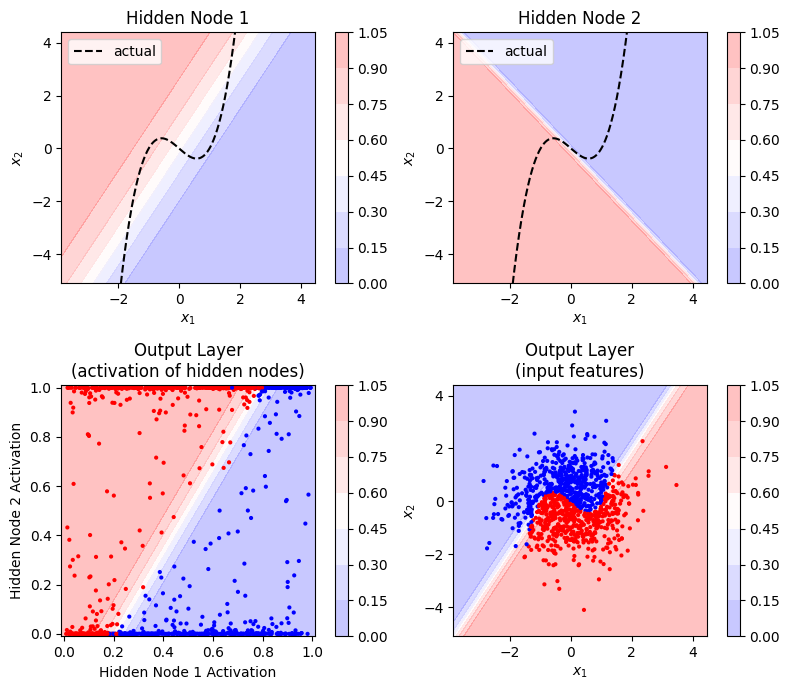

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7))

# 1st hidden node
w00 = model[0].weight[0]
b00 = model[0].bias[0]
fn00 = lambda x: (w00 * x + b00).sum(axis=1)
g00 = sigmoid(fn00(X).detach())

plot_decision_boundary(
    X,
    y,
    fn00,
    show_data=False,
    show_actual=True,
    ax=ax[0][0],
    title="Hidden Node 1",
)

# 2nd hidden node
w01 = model[0].weight[1]
b01 = model[0].bias[1]
fn01 = lambda x: (w01 * x + b01).sum(axis=1)
g01 = sigmoid(fn01(X).detach())

plot_decision_boundary(
    X,
    y,
    fn01,
    show_data=False,
    show_actual=True,
    ax=ax[0][1],
    title="Hidden Node 2",
)

# Output node
a1 = np.array([g00.numpy(), g01.numpy()]).T  # output of hidden layer
fn10 = (
    lambda a1: model[2].weight[0][0] * a1[:, 0]
    + model[2].weight[0][1] * a1[:, 1]
    + model[2].bias
)

# Output vs. hiddden node activations
plot_decision_boundary(
    a1,
    y,
    fn10,
    show_data=True,
    ax=ax[1][0],
    show_actual=False,
    xlim=(-0.01, 1.01),
    ylim=(-0.01, 1.01),
    title="Output Layer\n(activation of hidden nodes)",
    xlabel="Hidden Node 1 Activation",
    ylabel="Hidden Node 2 Activation",
)


# Output vs. input data values
plot_decision_boundary(
    X,
    y,
    model,
    show_data=True,
    show_actual=False,
    ax=ax[1][1],
    title="Output Layer\n(input features)",
)

fig.tight_layout()

The colour scale shows the "activation" of the node (i.e. the output after applying the sigmoid function). One node in the hidden layer captures the upward (positive) slope of the decision boundary, and the other the downward (negative) slope. When combined in the output layer (and sigmoid applied), the points from the two classes are linearly separable (you can draw a linear decision boundary between them) with respect to the activation of the hidden nodes.

## Takeaway message

Adding non-linear activation functions (e.g. sigmoid) to the output of every node allows us to fit non-linear functions with neural networks.

## Stability of the fit (overfitting)

With more flexibility comes more potential for overfitting (poor performance on new data). Here's an example of fitting the two hidden layer network on an increasing number of data points:

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


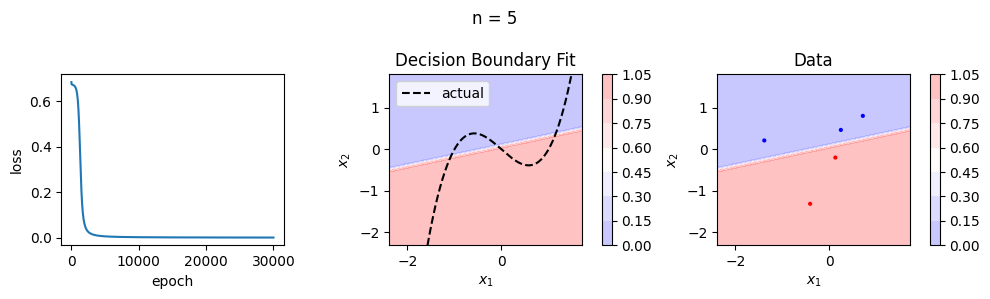

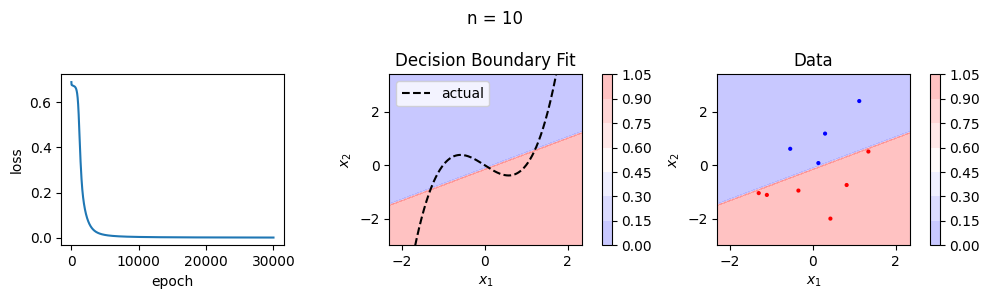

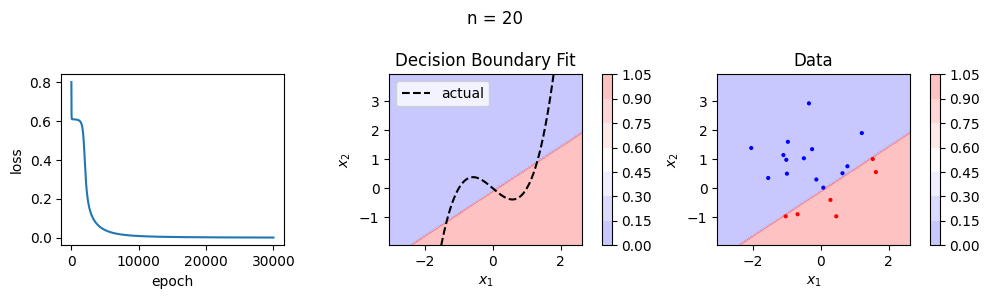

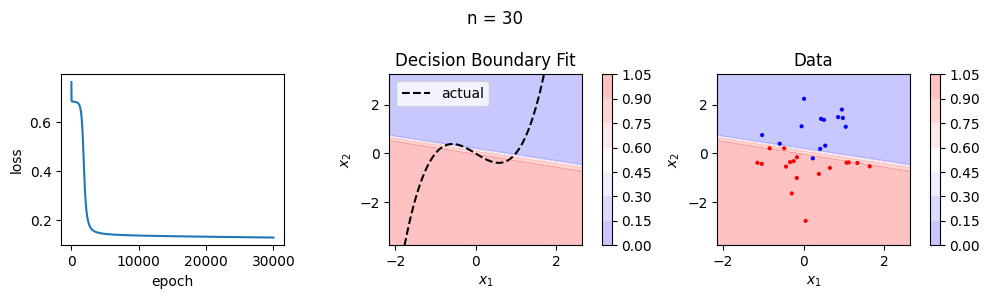

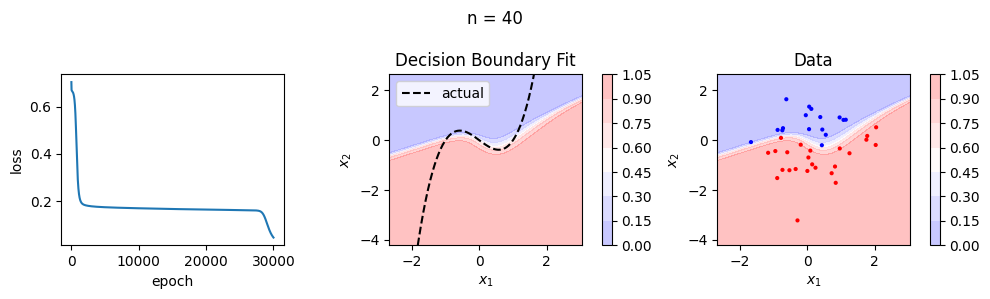

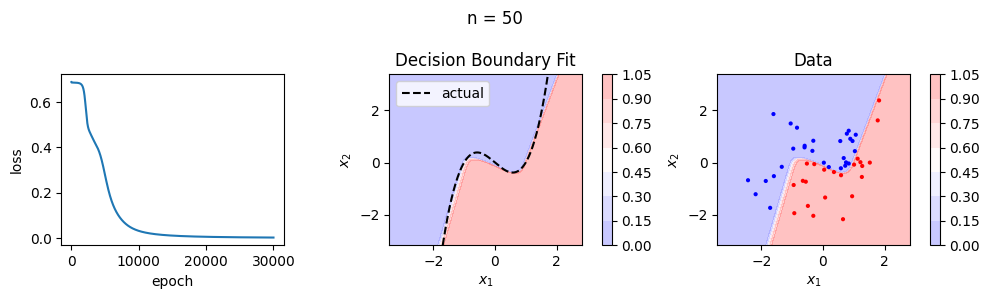

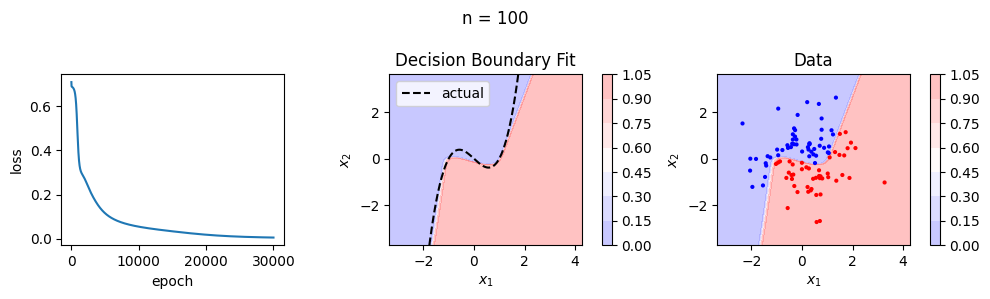

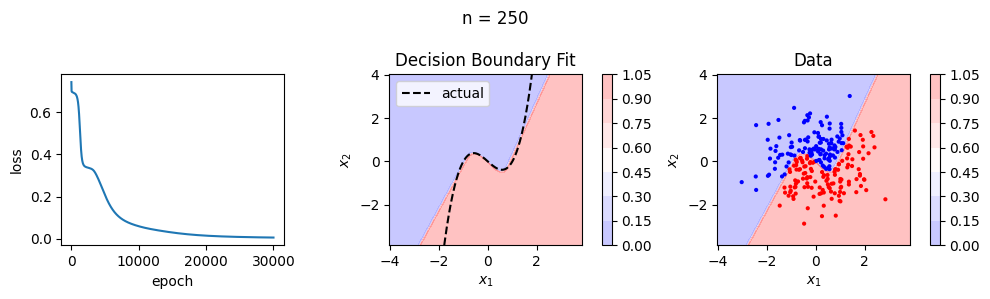

In [22]:
for n in [5, 10, 20, 30, 40, 50, 100, 250]:
    X, y = get_cubic_data(n)
    X = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    y = y[:, None]

    model = nn.Sequential(
        nn.Linear(in_features=2, out_features=3),
        nn.Sigmoid(),
        nn.Linear(in_features=3, out_features=3),
        nn.Sigmoid(),
        nn.Linear(in_features=3, out_features=1),
        #  Sigmoid (applied in loss_fn)
    )

    learning_rate = 0.1
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model, loss_history = train(X, y, model, loss_fn, optimizer, 30000)

    show_result(X, y, model, loss_history, print_weights=False, suptitle=f"n = {n}")